In [479]:
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import cv2
from importlib import reload
import pyvision ; reload(pyvision.lesson_functions)
from pyvision import utils, lesson_functions
%matplotlib inline

test_images_path = 'test_images/'
test_paths = utils.get_images_paths(test_images_path, '*.jpg')

### Extract one dark image and one light image

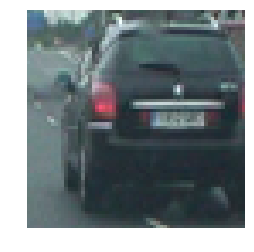

In [322]:
dark_image = utils.get_image('/Users/henriklarsson/Downloads/vehicles/GTI_MiddleClose/image0425.png')
plt.axis('off')
plt.imshow(dark_image);

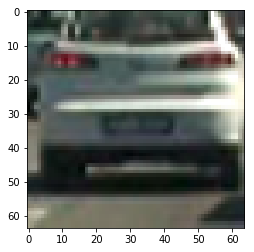

In [323]:
light_image = utils.get_image('/Users/henriklarsson/Downloads/vehicles/GTI_MiddleClose/image0218.png')
plt.imshow(light_image);

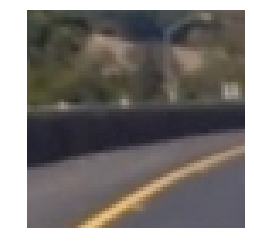

In [324]:
# Example of non-car image
non_car = utils.get_image('/Users/henriklarsson/Downloads/non-vehicles/Extras/extra998.png')
plt.axis('off')
plt.imshow(non_car);

## Experiment with HOG features to find good configuration on light and dark images

In [431]:
def plot_all_confs(image):
    rgb_hog_configs = [
        (16, 8, 2),
        (9, 10, 2),
        (9, 12, 2),
        (9, 14, 2),
        (9, 16, 2),
        (11, 8, 2),    
        (11, 10, 2),
        (11, 12, 2),
        (11, 14, 2),
        (11, 16, 2)
    ]
    hog_imgs = []
    hog_titles = []
    for o, p, c in rgb_hog_configs:
        one_colorspace_imgs = []
        one_colorspace_titles = []
        for channel in range(3):
            hog, hog_img = lesson_functions.get_hog_features(image[:,:,channel], 
                                                     orient=o, pix_per_cell=p, cell_per_block=c,
                                                     vis=True, feature_vec=False)
            one_colorspace_imgs.append(hog_img)
            one_colorspace_titles.append("o:{} px:{} c:{}, chan:{}".format(o, p, c, channel))
        hog_imgs.append(one_colorspace_imgs)
        hog_titles.append(one_colorspace_titles)
    utils.plot_list(hog_imgs, hog_titles, size=(32,32), title='RGB Color space')

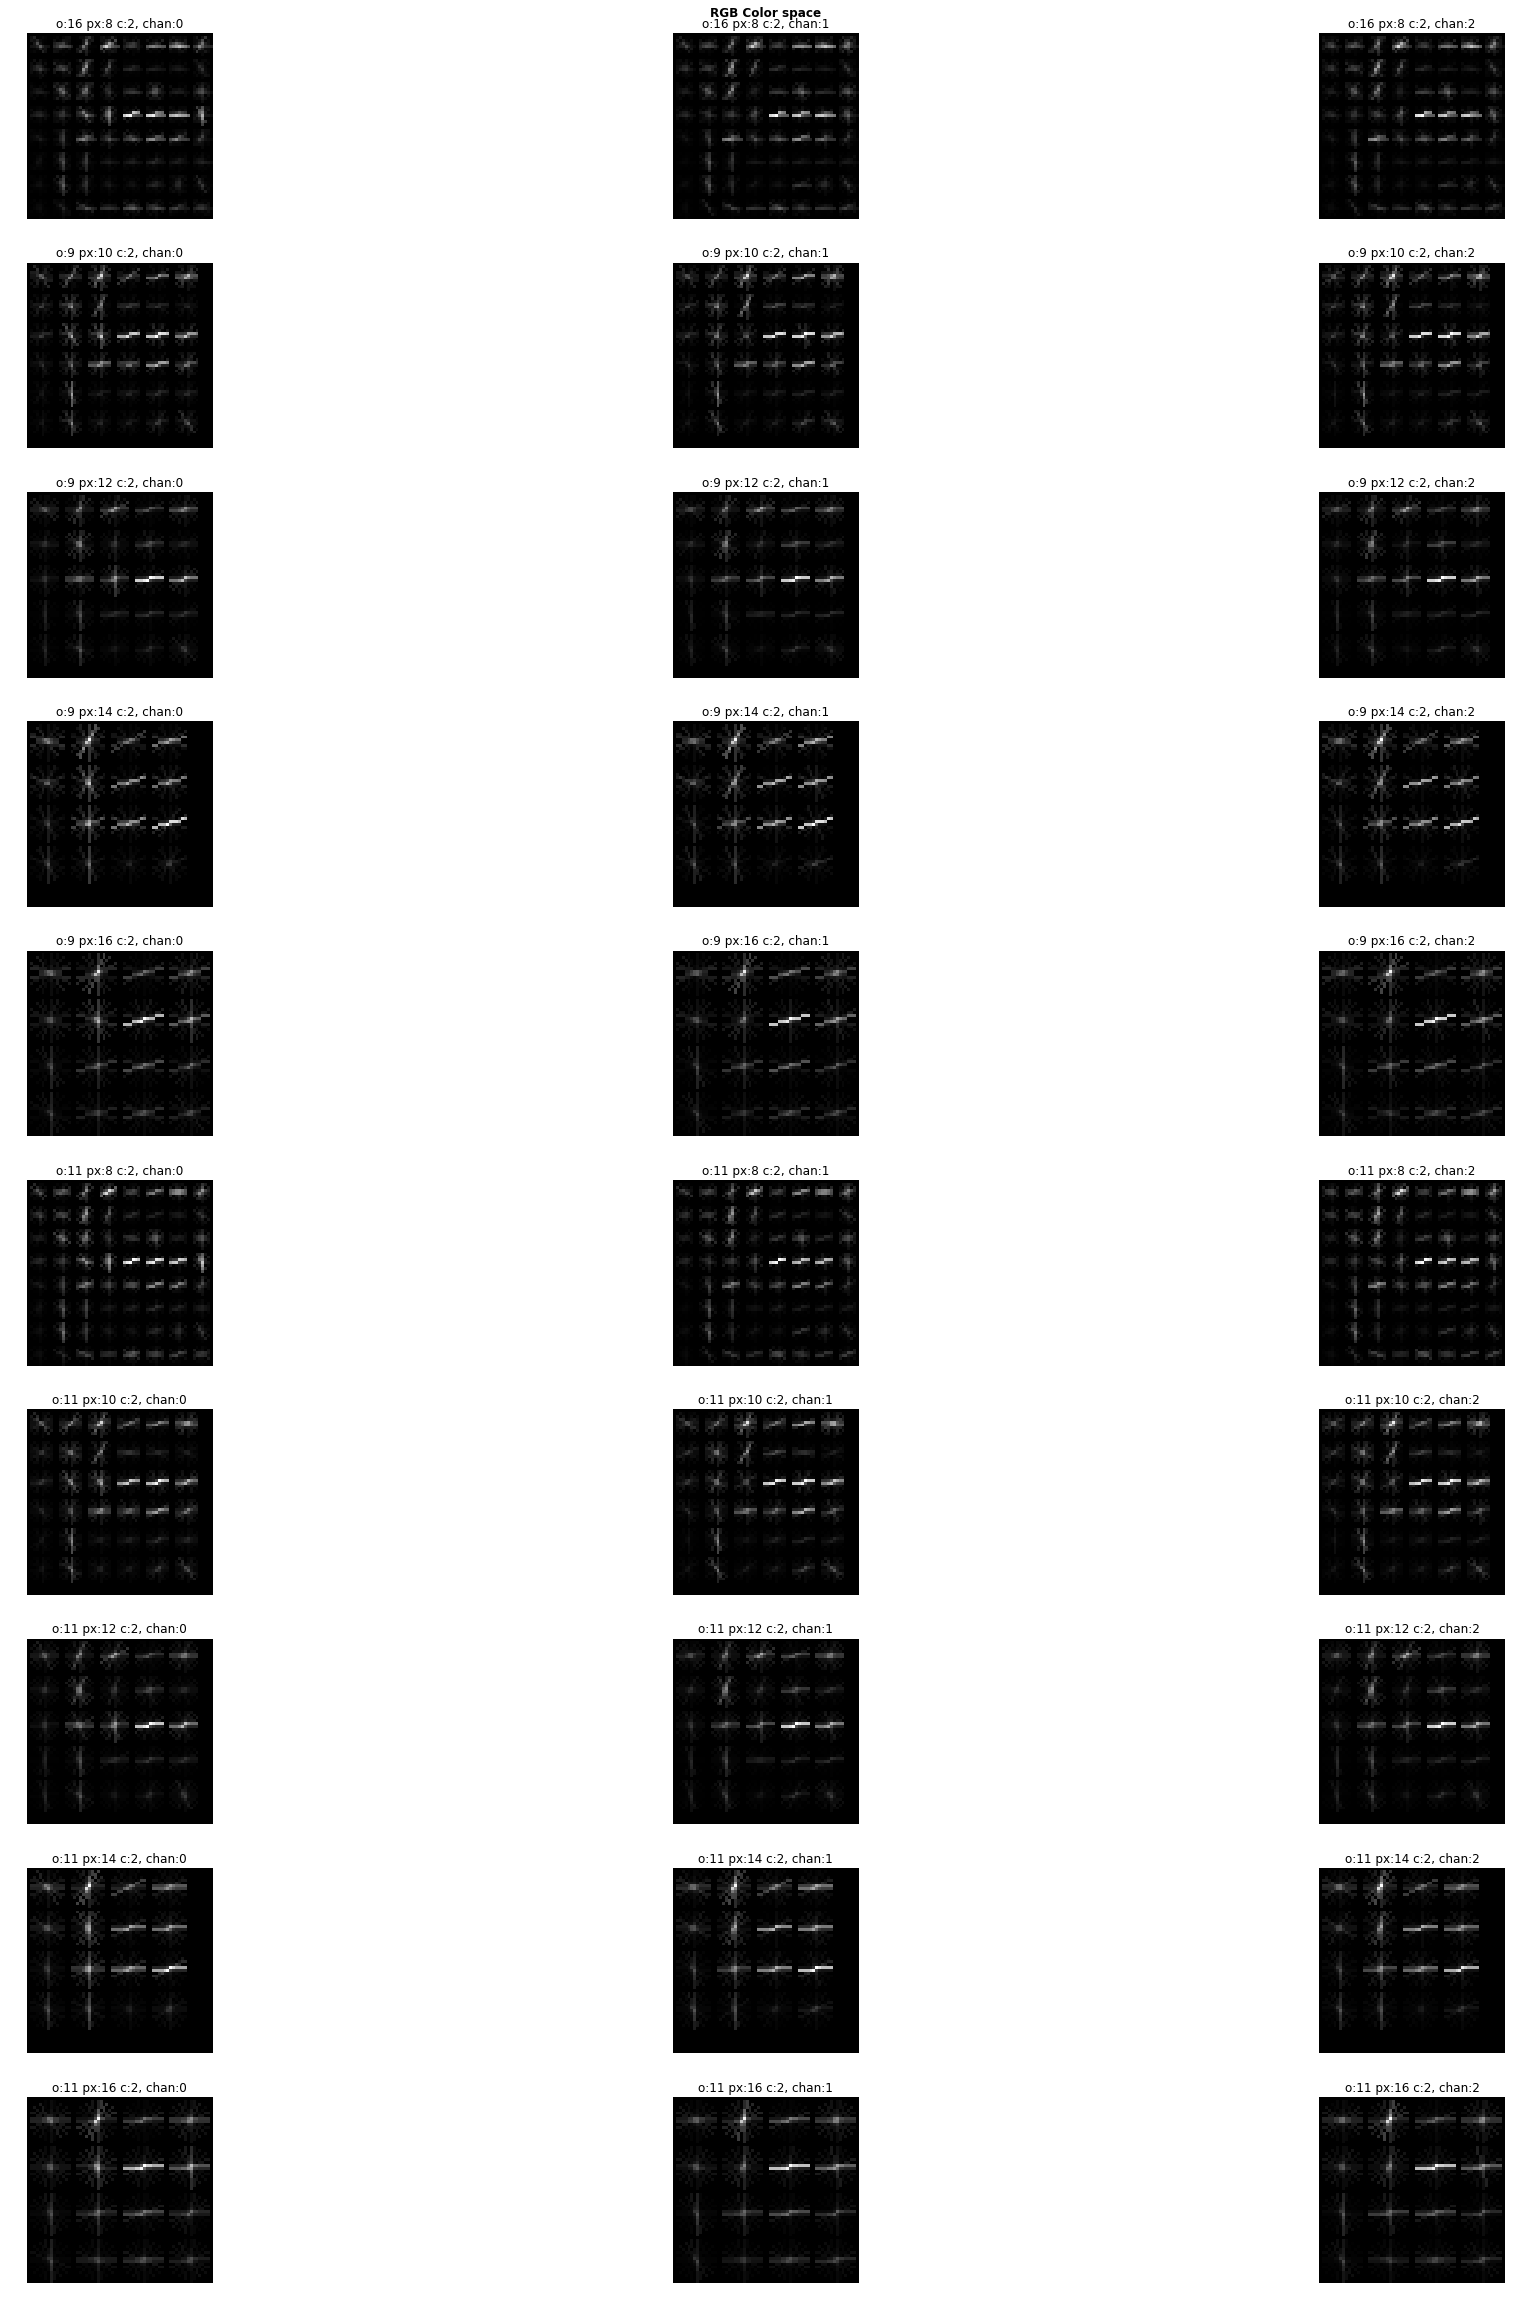

In [432]:
plot_all_confs(dark_image)

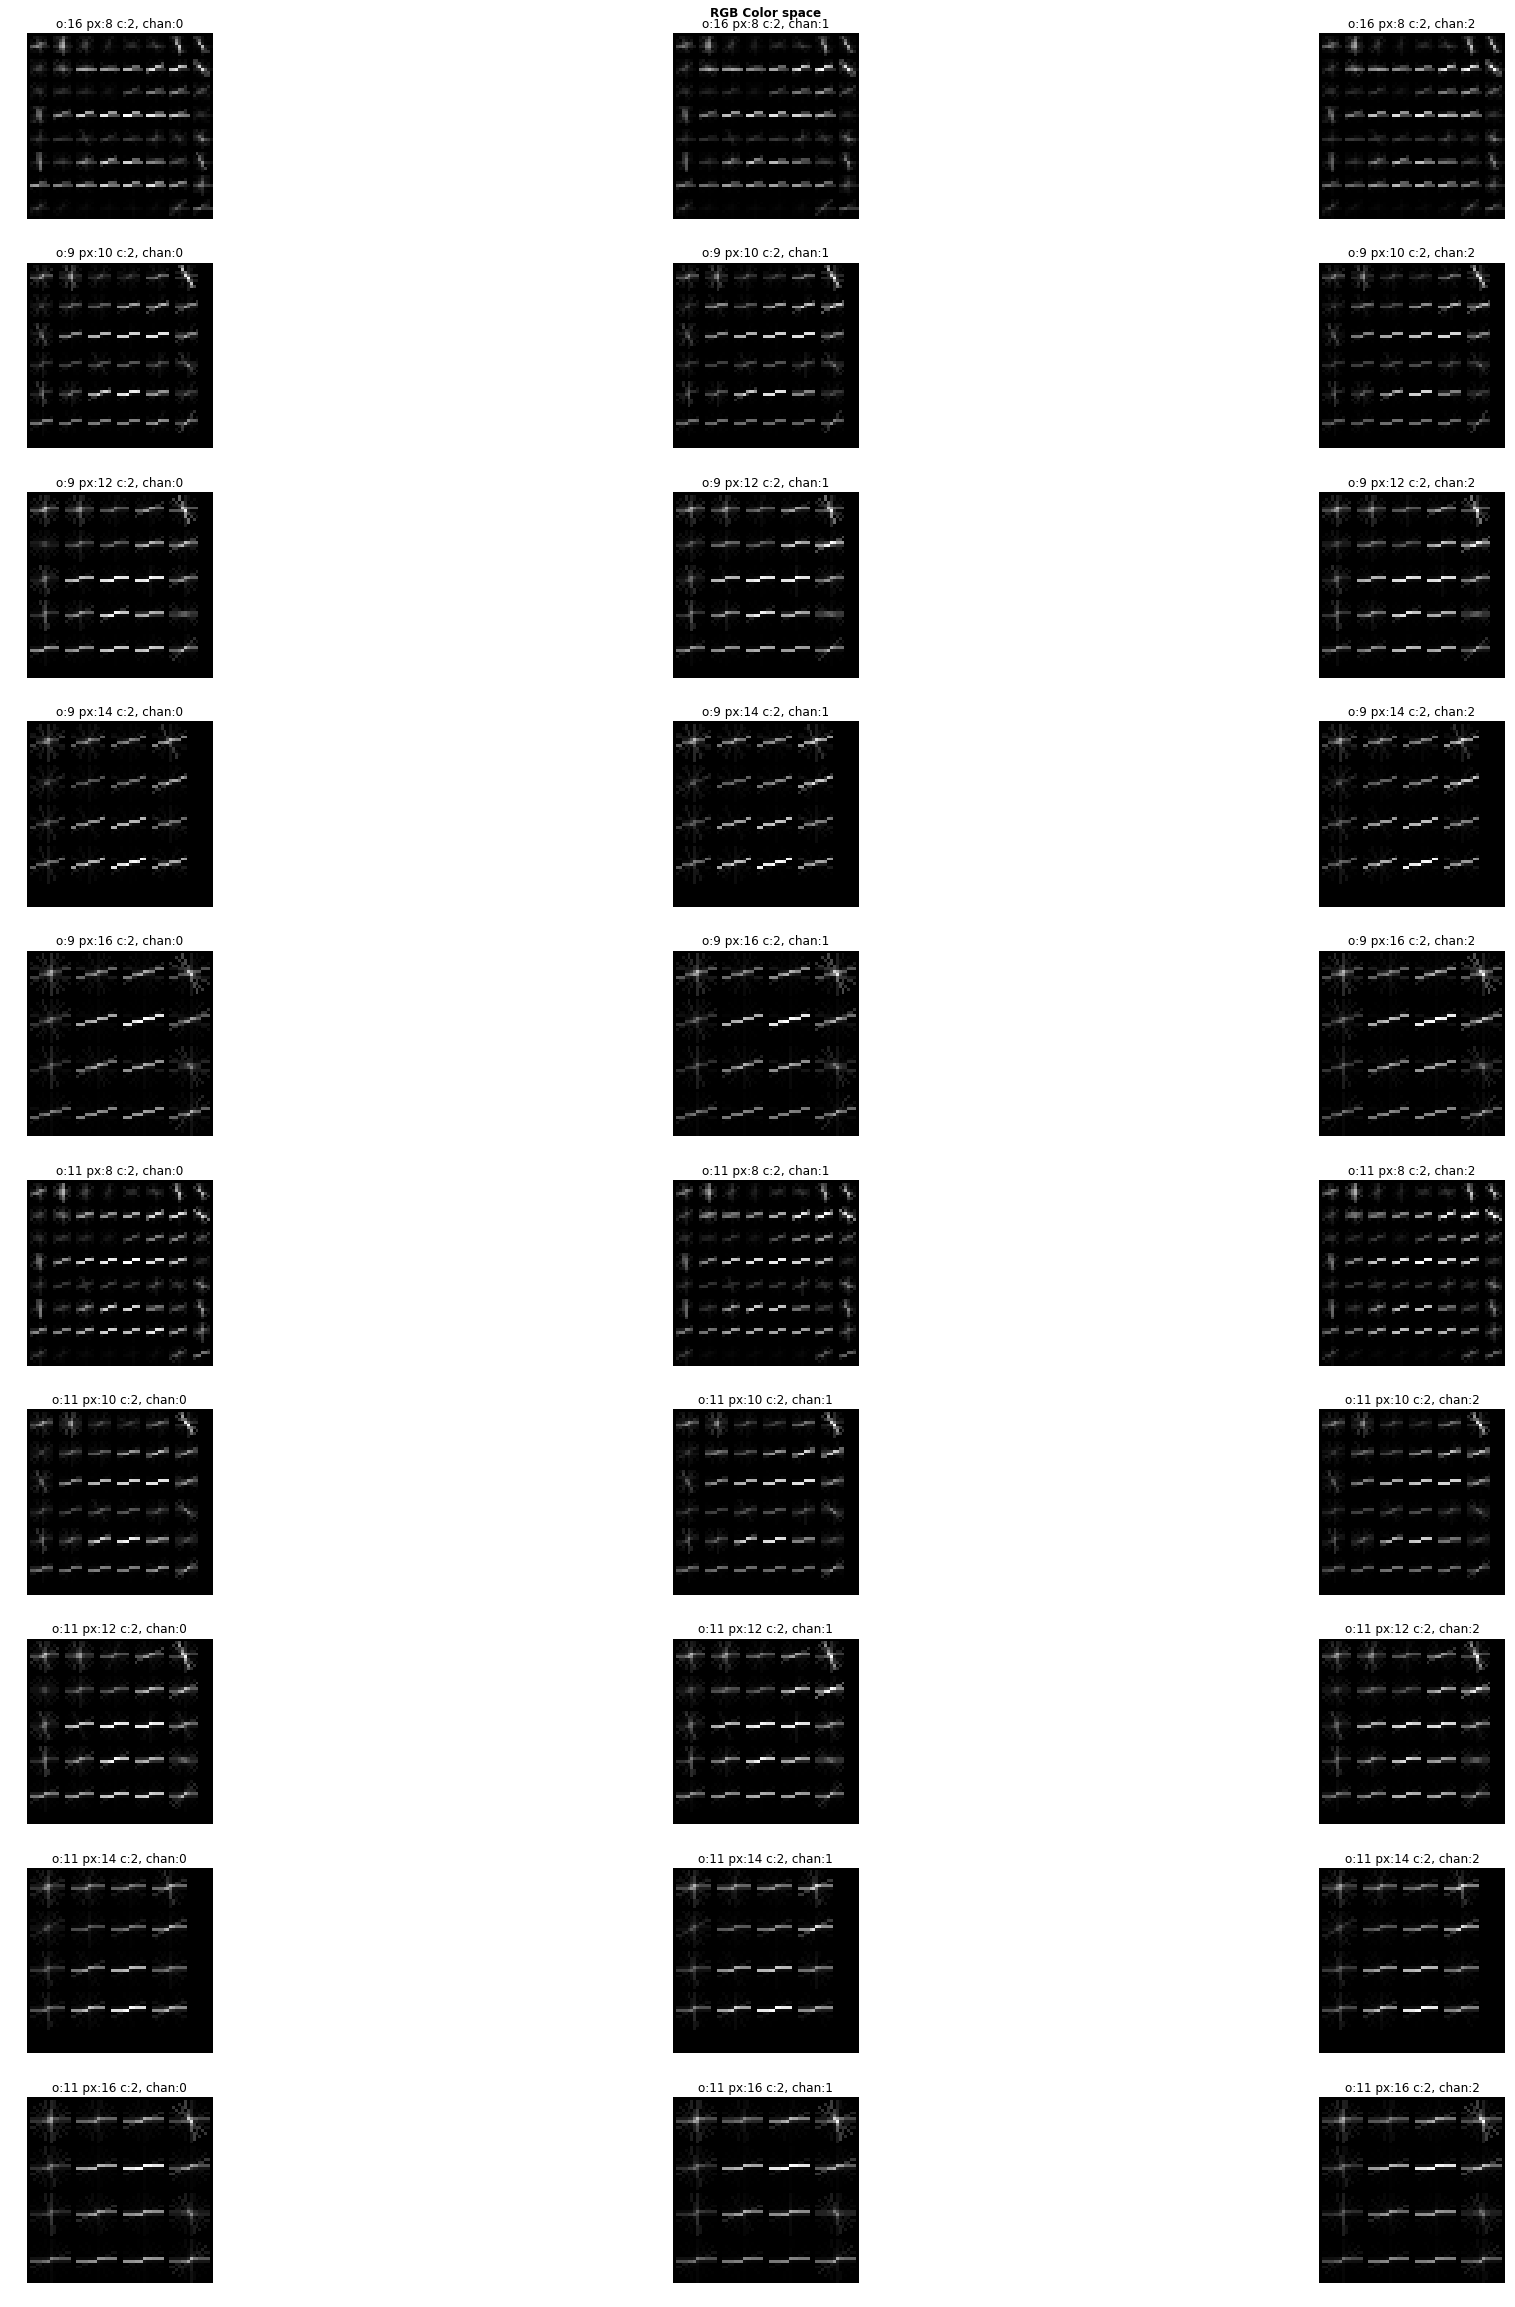

In [433]:
plot_all_confs(light_image)

In [450]:
# An orientation of 9 and 8 px looks to be consistently strong for light and dark examples
# also 2 block looks to be standard so from online guides so I will stick with this.
best_hog_config = (16,16,2)

In [329]:
def plot_all_colorspaces(image, best_hog_config):
    hog_color_spaces = [
    (image, 'RGB'),
    (cv2.cvtColor(image, cv2.COLOR_RGB2HSV), 'HSV'),
    (cv2.cvtColor(image, cv2.COLOR_RGB2LUV), 'LUV'),
    (cv2.cvtColor(image, cv2.COLOR_RGB2HLS), 'HLS'),
    (cv2.cvtColor(image, cv2.COLOR_RGB2YUV), 'YUV'),
    (cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb), 'YCrCb')
    ]
    hog_imgs = []
    hog_titles = []
    for img, space_text in hog_color_spaces:
        one_colorspace_imgs = []
        one_colorspace_titles = []
        for channel in range(3):
            hog, hog_img = lesson_functions.get_hog_features(
                img[:,:,channel], 
                orient=best_hog_config[0], 
                pix_per_cell=best_hog_config[1], 
                cell_per_block=best_hog_config[2],
                vis=True, feature_vec=False)
            one_colorspace_imgs.append(hog_img)
            one_colorspace_titles.append("{} chan:{}".format(space_text, channel))
        hog_imgs.append(one_colorspace_imgs)
        hog_titles.append(one_colorspace_titles)
    utils.plot_list(hog_imgs, hog_titles, size=(16, 16)) 

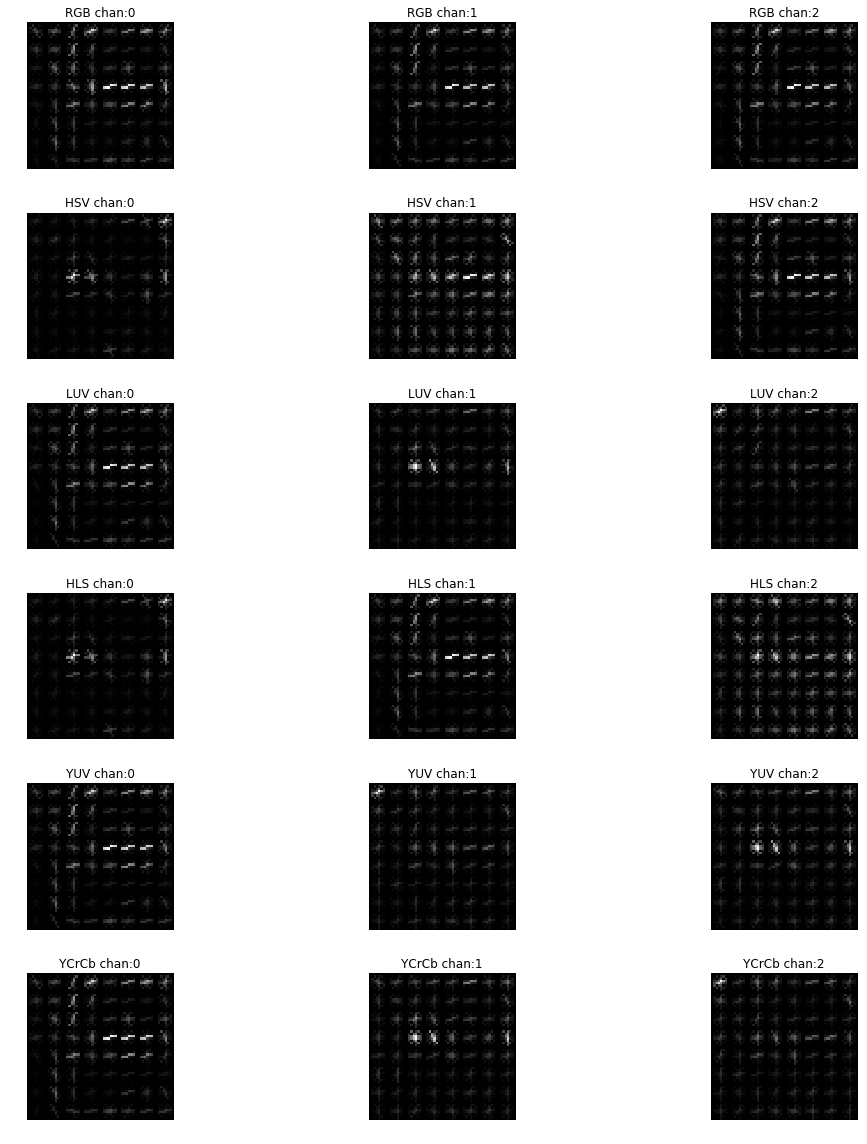

In [330]:
plot_all_colorspaces(dark_image, best_hog_config)

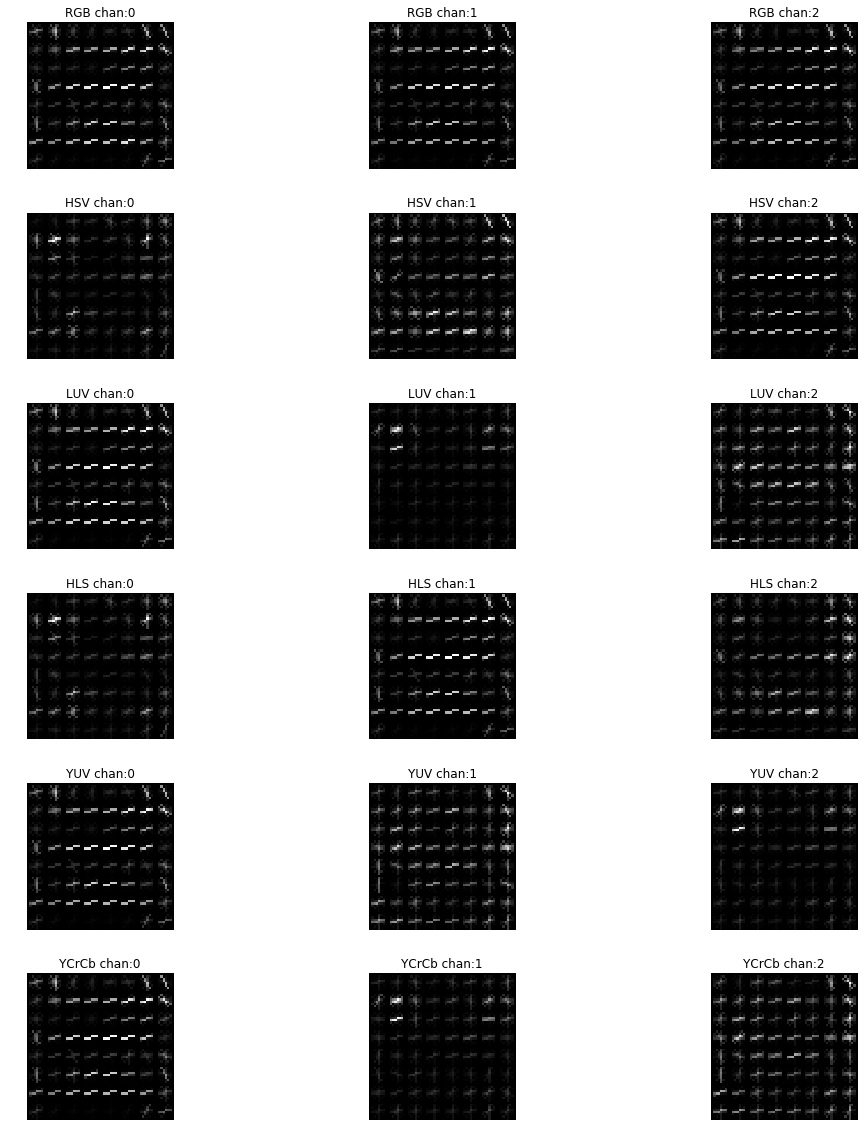

In [331]:
plot_all_colorspaces(light_image, best_hog_config)

In [410]:
# It looks looks like channels that carries light information stugles on the dark image so
# I will use all channels
best_hog_color_space = 'YCrCb'
best_hog_color_channels = 'ALL'

## Combining all features and check how large will our final statespace be

In [333]:
hog_feat = lesson_functions.single_img_features(
    light_image,
    color_space=best_hog_color_space, spatial_size=(16,16), hist_bins=32,
    orient=best_hog_config[0], pix_per_cell=best_hog_config[1], 
    cell_per_block=best_hog_config[2], hog_channel=best_hog_color_channels,
    spatial_feat=False, hist_feat=False, hog_feat=True
)
spatial_feat = lesson_functions.single_img_features(
    light_image,
    color_space=best_hog_color_space, spatial_size=(16,16), hist_bins=32,
    orient=best_hog_config[0], pix_per_cell=best_hog_config[1], 
    cell_per_block=best_hog_config[2], hog_channel=best_hog_color_channels,
    spatial_feat=True, hist_feat=False, hog_feat=False
)
hist_feat = lesson_functions.single_img_features(
    light_image,
    color_space=best_hog_color_space, spatial_size=(16,16), hist_bins=32,
    orient=best_hog_config[0], pix_per_cell=best_hog_config[1], 
    cell_per_block=best_hog_config[2], hog_channel=best_hog_color_channels,
    spatial_feat=False, hist_feat=True, hog_feat=False
)
all_feat = lesson_functions.single_img_features(
    light_image,
    color_space=best_hog_color_space, spatial_size=(16,16), hist_bins=32,
    orient=best_hog_config[0], pix_per_cell=best_hog_config[1], 
    cell_per_block=best_hog_config[2], hog_channel=best_hog_color_channels,
    spatial_feat=True, hist_feat=True, hog_feat=True
)
'#hog features: {} #spatial features: {} #hist features: {} all features: {}'.format(len(hog_feat), len(spatial_feat), len(hist_feat), len(all_feat))

# As a future experiment it would be fun to see if I could use PCA to reduce the statespace.

'#hog features: 5292 #spatial features: 768 #hist features: 96 all features: 6156'

## Training a classifier on the optimal values

In [502]:
# Using a grid search to find best values for classifier see file classifier.py 
# for what parameters I tested
# Best values found was:
# kernel=linear C=100

# Training a calssifier with the best found values see file classifier.py with an 
# accuracy of 98,5%

# Load in the best trained classifier
from sklearn.externals import joblib
svc = joblib.load('model.pkl')
X_scaler = joblib.load('scaler.pkl')

### Test classifier on car vs non car images

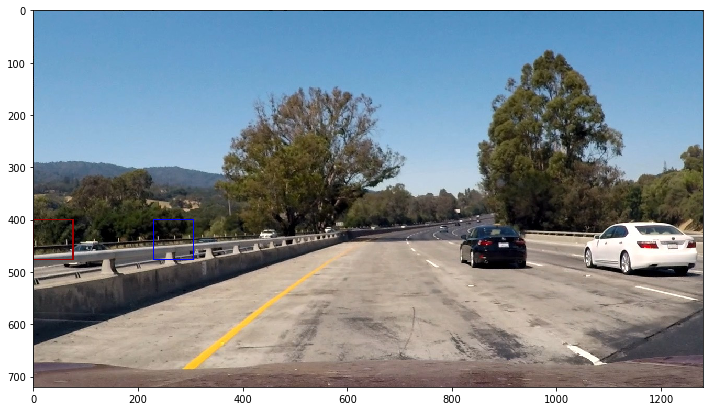

In [478]:
image = utils.get_image('test_images/test1.jpg')
# Show all classification matches given some scale
ystart = 400
ystop = 656
scale = 1.2
bboxes, all_boxes = lesson_functions.find_cars(image, ystart, ystop, scale, svc, X_scaler, 
                              best_hog_config[0], best_hog_config[1], best_hog_config[2], 
                              (16,16), 32)
plt.figure(figsize=(12,8))
plt.imshow(lesson_functions.draw_boxes(image, bboxes));

### Finding best search areas for sliding window
We want to be able to find cars with different distances to our car so we will not try different search areas

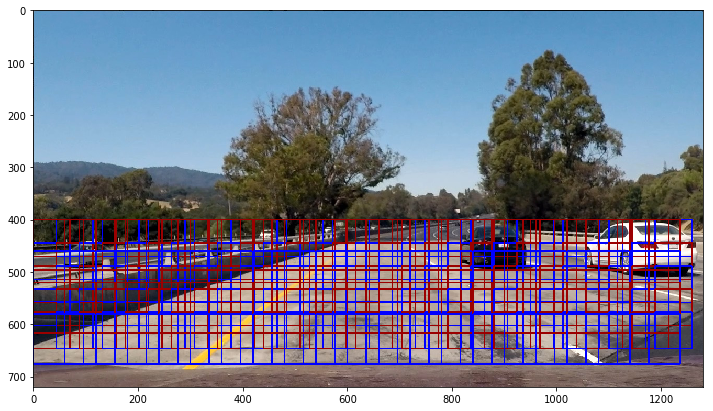

In [429]:
def windows_search(image, return_all=False):
    window_configs = [
    #(ystart, ystop, scale)
        (400, 680, 1.1),
        (400, 680, 1.5),
        #(400, 600, 1.25),
        #(350, 600, 1.),
        #(400, 528, 2.),
        #(432, 560, 2.),
        #(400, 596, 3.5),
        #(464, 660, 3.5)
    ]
    all_boxes = []
    for ystart, ystop, scale in window_configs:
        bboxes, windows = lesson_functions.find_cars(image, ystart, ystop, scale, svc, X_scaler, 
                                  best_hog_config[0], best_hog_config[1], best_hog_config[2], 
                                  (16,16), 32)
        if return_all:
            all_boxes.append(windows)
        else:
            all_boxes.append(bboxes)
    return [item for sublist in all_boxes for item in sublist] # flatten list
plt.figure(figsize=(12,8))
image = utils.get_image('test_images/test1.jpg')
plt.imshow(lesson_functions.draw_boxes(image, windows_search(image, return_all=True), thick=2));

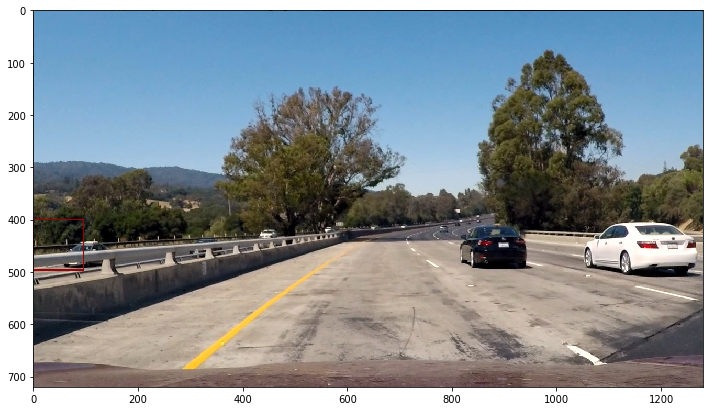

In [430]:
# Show only where classifier thinks there is a car
image = utils.get_image('test_images/test1.jpg')
plt.figure(figsize=(12,8))
plt.imshow(lesson_functions.draw_boxes(image, windows_search(image), thick=2));

## Heatmap

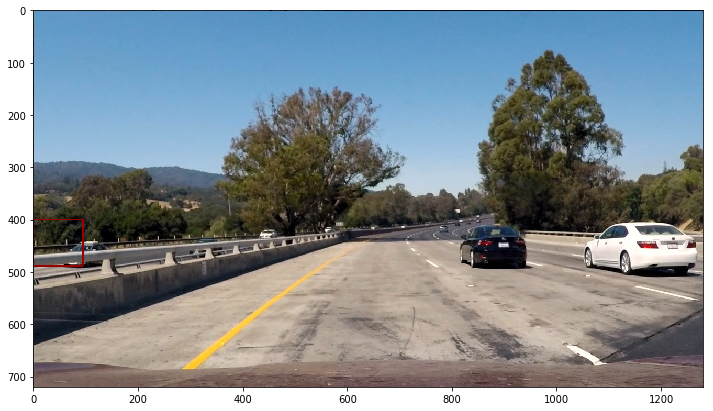

In [428]:
all_cars_bboxes = windows_search(image)
heat, heat_thres, heat_labels, heat_boxes = lesson_functions.heat_pipeline(image, all_cars_bboxes, threshold=1)
# Draw the aggregated boxes
plt.figure(figsize=(12,8))
plt.imshow(lesson_functions.draw_boxes(image, heat_boxes));

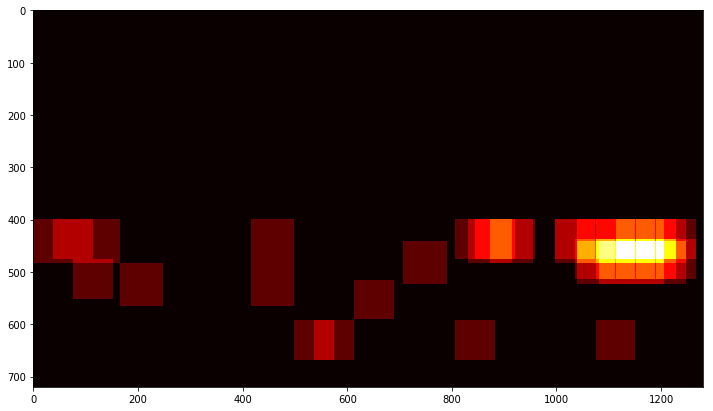

In [339]:
# How is the actual heatmap looking
plt.figure(figsize=(12,8))
plt.imshow(heat * 255, cmap="hot");

Number of cars found:  4


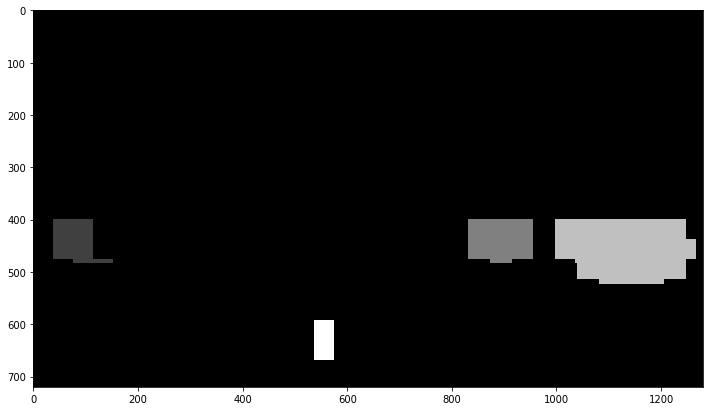

In [340]:
# And how many cars have been identified
plt.figure(figsize=(12,8))
plt.imshow(heat_labels[0], cmap="gray");
print("Number of cars found: ", heat_labels[1])

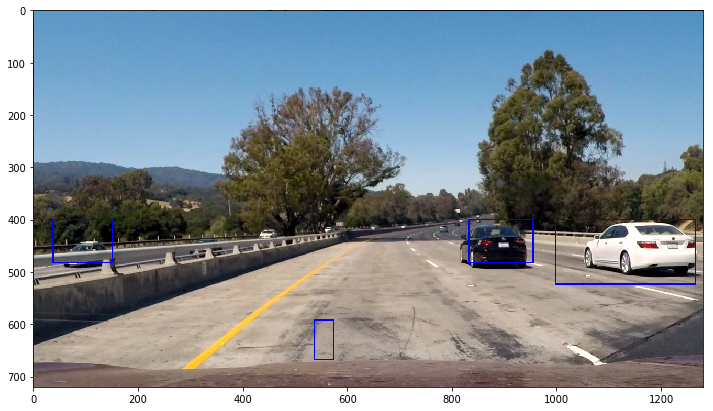

In [341]:
# Draw the labeled boxes
plt.figure(figsize=(12,8))
plt.imshow(lesson_functions.draw_labeled_bboxes(image, heat_labels));

# Pipeline 1

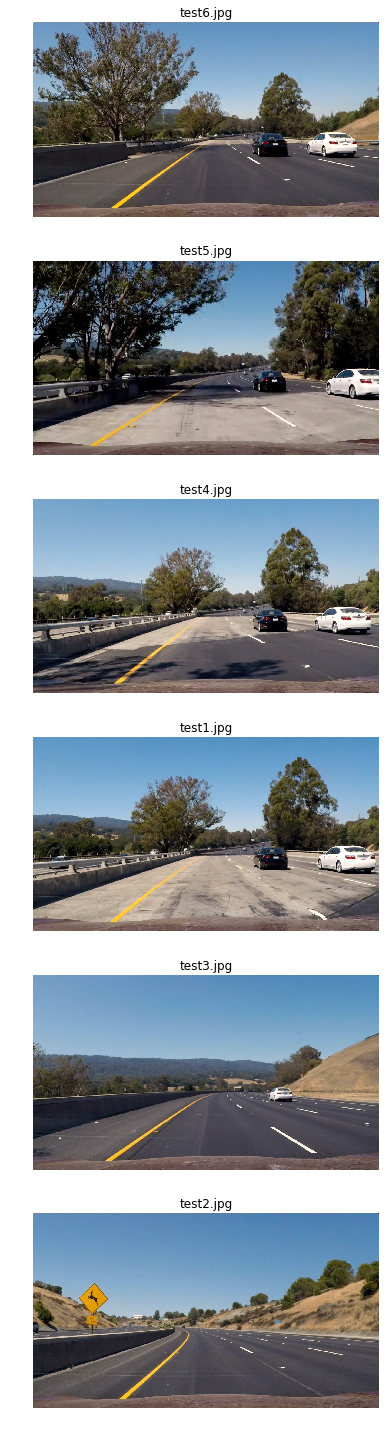

In [386]:
# only process each frame and do not account for objects detected in preavious frames
def pipeline1(img):
    all_cars_bboxes = windows_search(img)
    heat, heat_thres, heat_labels, heat_boxes = lesson_functions.heat_pipeline(img, all_cars_bboxes, threshold=1)
    return lesson_functions.draw_labeled_bboxes(img, heat_labels)
utils.apply_and_plot(pipeline1, test_paths)

# Pipline 2 with memory

In [343]:
from collections import deque
class CarFinder:
    def __init__(self, nframes=10):
        '''
        nframes is the number of frames we should create the heatmap over
        '''
        self.nframes = nframes
        self.hist = deque([], self.nframes)

    def pipeline(self, img):
        '''
        Entry point for car finding pipeline
        '''
        all_cars_bboxes = windows_search(img)
        # add all boxes found for the frame with boxes from other frames
        self.hist.append(all_cars_bboxes)
        # for the first n frames just return the image
        if len(self.hist) < self.nframes:
            return img
        flattened_boxes = [item for sublist in list(self.hist) for item in sublist]
        heat, heat_thres, heat_labels, heat_boxes = lesson_functions.heat_pipeline(img, flattened_boxes, threshold=self.nframes)

        return lesson_functions.draw_labeled_bboxes(img, heat_labels)

### Run pipline on video

In [345]:
from moviepy.editor import VideoFileClip
car_finder = CarFinder(nframes=20)
write_output_path = 'output_video/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(0,10)
challange_clip = clip1.fl_image(car_finder.pipeline)
%time challange_clip.write_videofile(write_output_path, audio=False)

[MoviePy] >>>> Building video output_video/project_video.mp4
[MoviePy] Writing video output_video/project_video.mp4



 12%|█▏        | 152/1261 [03:32<30:32,  1.65s/it]


 24%|██▍       | 303/1261 [06:50<20:55,  1.31s/it]


 36%|███▌      | 454/1261 [09:56<16:11,  1.20s/it]


 48%|████▊     | 605/1261 [13:03<15:01,  1.37s/it]


 60%|█████▉    | 756/1261 [16:12<10:41,  1.27s/it]


 72%|███████▏  | 907/1261 [19:15<06:49,  1.16s/it]


 84%|████████▍ | 1057/1261 [22:17<04:25,  1.30s/it]


 96%|█████████▌| 1205/1261 [25:21<01:09,  1.24s/it]


100%|█████████▉| 1260/1261 [26:28<00:01,  1.24s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video.mp4 

CPU times: user 38min 51s, sys: 1min 9s, total: 40min
Wall time: 26min 29s


# Pipeline 3 trial with simple window slider

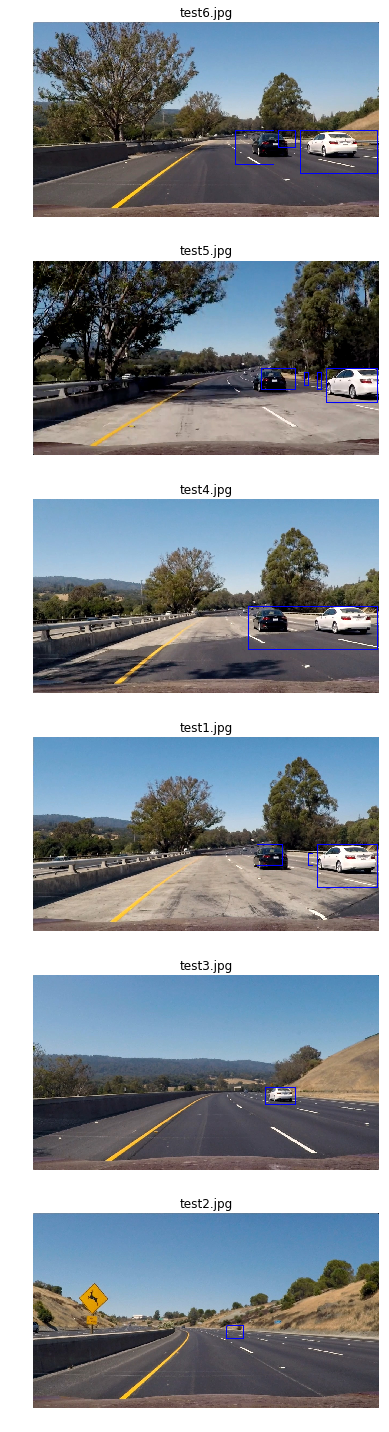

In [528]:
def process_frame(image, scales=[1,2]):
    windows = []
    for s in scales:
        w = lesson_functions.slide_window(image, x_start_stop=[700, 1280], y_start_stop=[400, 600],
                        xy_window=(64*s, 64*s), xy_overlap=(.75, .75))
        windows.append(w)
    windows = [item for sublist in windows for item in sublist]
    

    car_windows = lesson_functions.search_windows(image, windows, svc, X_scaler, color_space='YCrCb',
                            spatial_size=(16, 16), hist_bins=32,
                            hist_range=(0, 256), orient=16,
                            pix_per_cell=16, cell_per_block=2,
                            hog_channel='ALL', spatial_feat=True,
                            hist_feat=True, hog_feat=True)

    
    heat, heat_thres, heat_labels, heat_boxes = lesson_functions.heat_pipeline(image, car_windows, threshold=1)
    return lesson_functions.draw_labeled_bboxes(image, heat_labels)

#image = utils.get_image('test_images/test1.jpg')
#plt.figure(figsize=(12,8))
#plt.imshow(lesson_functions.draw_boxes(image, car_windows, thick=2));
utils.apply_and_plot(process_frame, test_paths)

# Pipeline with memory 4

In [529]:
from collections import deque
class CarFinder2:
    def __init__(self, scales=[1], nframes=10):
        '''
        nframes is the number of frames we should create the heatmap over
        '''
        self.scales = scales
        self.nframes = nframes
        self.hist = deque([], self.nframes)

    def pipeline(self, image):
        '''
        Entry point for car finding pipeline
        '''
        windows = []
        for s in self.scales:
            w = lesson_functions.slide_window(image, x_start_stop=[700, 1280], y_start_stop=[400, 600],
                            xy_window=(64*s, 64*s), xy_overlap=(.75, .75))
            windows.append(w)
        windows = [item for sublist in windows for item in sublist]


        car_windows = lesson_functions.search_windows(image, windows, svc, X_scaler, color_space='YCrCb',
                                spatial_size=(16, 16), hist_bins=32,
                                hist_range=(0, 256), orient=16,
                                pix_per_cell=16, cell_per_block=2,
                                hog_channel='ALL', spatial_feat=True,
                                hist_feat=True, hog_feat=True)
        # add all boxes found for the frame with boxes from other frames
        self.hist.append(car_windows)
        # for the first n frames just return the image
        if len(self.hist) < self.nframes:
            return image
        flattened_boxes = [item for sublist in list(self.hist) for item in sublist]
        heat, heat_thres, heat_labels, heat_boxes = lesson_functions.heat_pipeline(image, flattened_boxes, threshold=self.nframes*2)

        return lesson_functions.draw_labeled_bboxes(image, heat_labels)

In [530]:
from moviepy.editor import VideoFileClip
car_finder = CarFinder2(nframes=10)
write_output_path = 'output_video/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4") #.subclip(0,10)
challange_clip = clip1.fl_image(car_finder.pipeline)
%time challange_clip.write_videofile(write_output_path, audio=False)

[MoviePy] >>>> Building video output_video/project_video.mp4
[MoviePy] Writing video output_video/project_video.mp4



 12%|█▏        | 152/1261 [03:29<25:23,  1.37s/it]


 24%|██▍       | 303/1261 [06:57<21:51,  1.37s/it]


 36%|███▌      | 454/1261 [10:24<18:17,  1.36s/it]


 48%|████▊     | 605/1261 [13:49<14:42,  1.34s/it]


 60%|█████▉    | 756/1261 [17:16<11:41,  1.39s/it]


 72%|███████▏  | 907/1261 [20:43<08:03,  1.36s/it]


 84%|████████▍ | 1057/1261 [24:10<04:38,  1.36s/it]


 96%|█████████▌| 1205/1261 [27:33<01:16,  1.37s/it]


100%|█████████▉| 1260/1261 [28:49<00:01,  1.37s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video.mp4 

CPU times: user 31min 35s, sys: 19.9 s, total: 31min 55s
Wall time: 28min 50s
